In [2]:
from os import path
import importlib
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
_ = torch.manual_seed(1)

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
# We will use Shakespeare Sonnet 2
training_story = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)

In [4]:
CONTEXT_SIZE = 4
EMBEDDING_DIM = 10

ngrams = [
    (
        [training_story[i - j - 1] for j in range(CONTEXT_SIZE)],
        training_story[i]
    )
    for i in range(CONTEXT_SIZE, len(training_story))
]

print(ngrams[:3])

vocab = set(training_story)
vocab.update([' '])
# word_to_ix = {word: i for i, word in enumerate(vocab)}

word_to_ix = {word: ix for ix, word in enumerate(vocab)}
ix_to_word = {ix: word for ix, word in enumerate(vocab)}

def get_context_vector(context):
    idxs = [word_to_ix[w] for w in context] 
    return torch.tensor(idxs, dtype=torch.long)

[(['shall', 'winters', 'forty', 'When'], 'besiege'), (['besiege', 'shall', 'winters', 'forty'], 'thy'), (['thy', 'besiege', 'shall', 'winters'], 'brow,')]


In [15]:
class MODEL(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(MODEL, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1 )
        return log_probs

In [16]:
model = MODEL(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
loss0 = None
for epoch in range(150):
    total_loss = 0
    for context, target in ngrams:
        context_vector = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        model.zero_grad()
        log_probs = model(context_vector)
        loss = loss_function(log_probs, torch.tensor(
            [word_to_ix[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if loss0 is None:
        loss0 = total_loss

print(f'start loss: {loss0:.1e}, stop loss: {total_loss:.1e}')

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [8]:
print(sorted(list(vocab)))

[' ', "'This", 'And', 'How', 'If', 'Proving', 'Shall', 'Then', 'This', 'Thy', 'To', 'Were', 'When', 'Where', 'Will', 'a', 'all', 'all-eating', 'an', 'and', 'answer', 'art', 'asked,', 'be', 'beauty', "beauty's", 'being', 'besiege', 'blood', 'brow,', 'by', 'child', 'cold.', 'couldst', 'count,', 'days;', 'deep', "deserv'd", 'dig', "excuse,'", 'eyes,', 'fair', "feel'st", 'field,', 'forty', 'gazed', 'held:', 'his', 'in', 'it', 'lies,', 'livery', 'lusty', 'made', 'make', 'mine', 'more', 'much', 'my', 'new', 'now,', 'of', 'old', 'old,', 'on', 'own', 'praise', 'praise.', 'proud', 'say,', 'see', 'shall', 'shame,', 'small', 'so', 'succession', 'sum', 'sunken', 'the', 'thine', 'thine!', 'thou', 'thriftless', 'thy', 'to', "totter'd", 'treasure', 'trenches', 'use,', 'warm', 'weed', 'were', 'when', 'where', 'winters', 'within', 'worth', "youth's"]


In [9]:
data_idx = 20

In [14]:
data = ngrams[data_idx]
data_idx = (data_idx + 10) % len(ngrams)
context = data[0]
context[1] = ' '
print(f'context: {context}')
context_vector = get_context_vector(context)
a = model(context_vector)
print(a)
pred = ix_to_word[torch.argmax(a[0]).item()]

context_ = ' '.join(context)

# print(f'data: {data}')
# print(f'Context: {" ".join(context)}\n')
print(f'Fact:       {context_ + " " + data[1]}')

print(f'Prediction: {context_ + " " + pred}')

context: ['being', ' ', 'held:', 'worth']
tensor([[-4.3287, -4.2656, -3.6168, -5.4709, -5.4323, -5.6790, -5.4673, -3.2791,
         -3.7212, -4.6348, -4.9995, -5.3891, -4.7946, -4.8762, -4.4622, -4.8720,
         -4.3141, -4.7521, -5.3510, -4.9665, -4.7108, -5.7955, -5.7543, -5.0231,
         -5.9565, -4.2253, -5.9976, -3.7840, -3.4336, -5.2284, -4.3626, -4.3713,
         -5.2724, -4.4917, -4.8366, -5.8540, -5.4276, -4.7296, -5.4987, -6.0153,
         -4.4347, -5.2273, -2.2138, -4.4369, -4.5156, -4.1131, -5.1381, -5.2944,
         -4.8984, -5.4978, -5.7422, -5.0508, -4.8293, -5.1023, -4.6523, -5.0076,
         -5.5762, -3.8957, -5.4609, -4.3599, -5.9070, -4.7969, -5.7435, -5.5962,
         -4.7949, -5.8740, -5.0567, -5.6563, -5.3822, -4.0772, -5.4121, -5.2038,
         -5.9257, -4.1431, -4.6968, -4.4568, -3.3138, -5.1559, -4.5258, -5.7467,
         -5.1770, -5.2306, -3.5998, -4.4632, -5.5431, -5.1265, -4.0503, -4.8073,
         -5.1795, -5.1709, -3.8178, -5.6500, -5.5734, -4.6234, -4.3

In [11]:
def show_embeddings(embeddings, pca_n=3, palette='viridis'):
    """
    Parameters:
    -----------
    embeddings : ``nn.Embedding`` object
    palette : seaborn color palette name: 'viridis', 'hls'
    """
    weight = embeddings.weight.clone().detach()
    shape = weight.shape # torch.Size([896, 15])
    data_frame = pd.DataFrame(embeddings.weight.clone().detach())
    data_frame.columns = [str(_) for _ in range(shape[1])]

    pca = PCA(n_components=pca_n) # Principal component analysis keeping n_components
    pca_result = pca.fit_transform(X=data_frame)
    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate=200)
    tsne_results = tsne.fit_transform(pca_result)

    plt.figure(figsize=(5, 4))
    sns.scatterplot(
    x=tsne_results[:,0], 
    y=tsne_results[:,1],
    hue=[_ for _ in range(shape[0])],
    palette=sns.color_palette(palette, shape[0]),
    legend=None,
    alpha=0.3
)

def get_embeddings_save_path(embedding_dim, context_size):
    return f'cbow_embeddings_{embedding_dim}_{context_size}.pkl'

def save_embeddings(embeddings, embedding_dim, context_size):
    with open(path.join(
            co.DATA_STORE, 
            get_embeddings_save_path(embedding_dim, context_size)), 'wb') as f:
        pickle.dump(embeddings, f)

def get_data_from_file(embedding_dim, context_size):      
    with open(
        path.join(
            co.DATA_STORE, 
            get_embeddings_save_path(embedding_dim, context_size)), 'rb') as f:
        data = pickle.load(f)
    return data

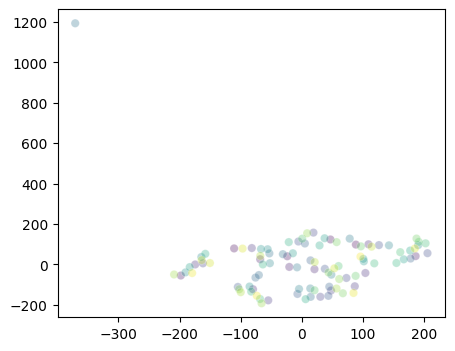

In [ ]:
show_embeddings(model.embeddings)

In [13]:
for context, _ in ngrams[:1]:

    # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
    # into integer indices and wrap them in tensors)
    context_vector = torch.tensor([word_to_ix[w] for w in context], 
        dtype=torch.long)
    

    print(model(torch.tensor([0, 0, 0, 0])))

tensor([[-4.5648, -4.2481, -4.8602, -3.9978, -3.2734, -4.3922, -4.8017, -5.3223,
         -4.5354, -3.9248, -4.0853, -4.3352, -5.7628, -5.5348, -3.8981, -5.0879,
         -5.3804, -5.5536, -4.7685, -3.9296, -4.9829, -4.1437, -5.2061, -3.9851,
         -5.1883, -5.1863, -5.3967, -4.2010, -3.4325, -4.9410, -4.8930, -5.3476,
         -4.7875, -3.0114, -4.2214, -5.7070, -5.3376, -5.9218, -4.0446, -5.9791,
         -4.4726, -4.2682, -5.0540, -4.4920, -5.1545, -4.4716, -5.7794, -4.8091,
         -4.4482, -4.8727, -5.9519, -4.7554, -4.7600, -5.9252, -4.7701, -5.6405,
         -3.7964, -4.6269, -3.3169, -3.0831, -5.9037, -5.8224, -5.1637, -4.5711,
         -5.0318, -5.0214, -4.5077, -3.9268, -5.4881, -5.6330, -5.6634, -6.3164,
         -4.3606, -4.5751, -5.6925, -4.7507, -4.9381, -5.5693, -5.7364, -6.3852,
         -3.8290, -5.5569, -4.2290, -5.9719, -5.4628, -4.7446, -5.3130, -5.2426,
         -5.8359, -5.6113, -5.2785, -5.8616, -5.2971, -5.8079, -4.2258, -3.4462,
         -4.1239, -5.8899]],